# Homework 5

## FINM 37400 - 2023

### UChicago Financial Mathematics

In [2]:
import pandas as pd
import numpy as np
import datetime
import warnings

from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize
from scipy.optimize import fsolve

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13
pd.set_option("display.precision", 4)

import sys
sys.path.insert(0, '../cmds')
from treasury_cmds import *

# 1. Forward Rates

Use the data set `treasury_zero_coupon_2022-12-30.xlsx`.

It gives prices on **zero coupon bonds** with maturities of 1 through 5 years.
* These are prices per \\$1 face value on bonds that only pay principal.
* Such bonds can be created from treasuries by *stripping* out their coupons.
* In essence, you can consider these prices as the discount factors $Z$, for maturity intervals 1 through 5 years.

In this problem, we focus on six dates: the month of December in 2017 through 2022.

In [3]:
ZeroCoupon = pd.read_excel("../data/treasury_zero_coupon_2022-12-30.xlsx", index_col=0)
ZeroCoupon.head()

,1,2,3,4,5
date,,,,,
1952-06-30,0.9818,0.9625,0.9425,0.9263,0.9042
1952-07-31,0.9809,0.9603,0.9393,0.9231,0.8985
1952-08-29,0.9806,0.9597,0.9378,0.9215,0.8957
1952-09-30,0.9803,0.9591,0.9376,0.9210,0.8917
1952-10-31,0.9811,0.9597,0.9376,0.9193,0.8972


In [4]:
sample = ZeroCoupon[(ZeroCoupon.index > "2017") & (ZeroCoupon.index < "2023") & (ZeroCoupon.index.month == 12)].copy()
sample

,1,2,3,4,5
date,,,,,
2017-12-29,0.9824,0.9631,0.9424,0.9189,0.8956
2018-12-31,0.9743,0.9520,0.9293,0.9058,0.8826
2019-12-31,0.9844,0.9689,0.9530,0.9357,0.9189
2020-12-31,0.9990,0.9975,0.9953,0.9895,0.9815
2021-12-31,0.9962,0.9855,0.9713,0.9549,0.9387
2022-12-30,0.9546,0.9162,0.8833,0.8510,0.8203


## 1.1

For each of the six dates, (Dec 2017, Dec 2018, ...), calculate the forward discount factor, $F(t,T_1,T_2)$, where $T_2 = T_1 + 1$ for $1\le T_1\le 4$.

Make a plot of the curve $F$ at each of these six dates.

In [5]:
Forward = sample.copy()
Forward[[2,3,4,5]] = sample.values[:, 1:]/sample.values[:, :-1]
Forward.columns = list(range(5))
Forward = Forward.T

In [6]:
Forward

date,2017-12-29,2018-12-31,2019-12-31,2020-12-31,2021-12-31,2022-12-30
0,0.9824,0.9743,0.9844,0.9990,0.9962,0.9546
1,0.9804,0.9771,0.9843,0.9986,0.9893,0.9598
2,0.9785,0.9762,0.9835,0.9978,0.9855,0.9641
3,0.9750,0.9747,0.9819,0.9941,0.9831,0.9634
4,0.9747,0.9744,0.9820,0.9920,0.9830,0.9639


Text(0, 0.5, 'discount factor')

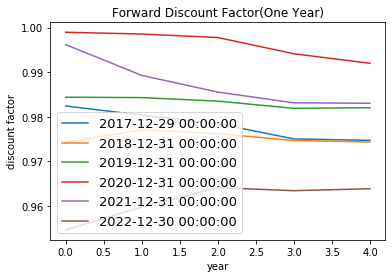

In [7]:
plt.plot(Forward)
plt.title("Forward Discount Factor(One Year)")
plt.legend(Forward.columns, loc='best')
plt.xlabel("year")
plt.ylabel("discount factor")

## 1.2



Use $F$ above to calculate the continuously compounded forward rates, $f$, at the six dates.

Make a plot of the curve, $f$, at each of these six dates.

Text(0, 0.5, 'forward rate')

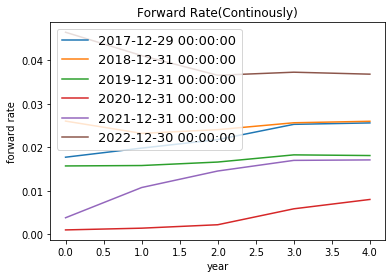

In [8]:
f = - np.log(Forward)
plt.plot(f)
plt.title("Forward Rate(Continously)")
plt.legend(f.columns, loc='best')
plt.xlabel("year")
plt.ylabel("forward rate")

## 1.3

Calculate the continuously compounded spot rates, $r$, at the six dates.

Plot both the forward curve and the spot curve on the date of Dec 2017.

Recall that $f(t,t,t+1) = r(t,t+1)$.

Text(0, 0.5, 'rate')

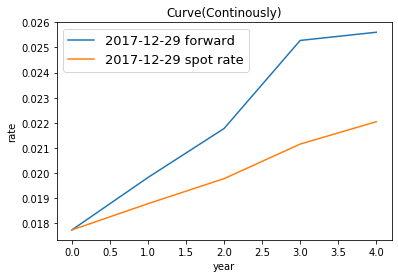

In [9]:
spot_rate = - np.log(sample)/np.array([1, 2, 3, 4, 5])
spot_forward = f[["2017-12-29"]].copy()
spot_forward["spot rate"] = spot_rate.values[0, :].T
spot_forward.columns = ["2017-12-29 forward", "2017-12-29 spot rate"]
spot_forward.plot()
plt.title("Curve(Continously)")
plt.xlabel("year")
plt.ylabel("rate")

## 1.4

Plot the forward curve on Dec 2017 against the time-series evolution of $r(t,t+1)$ for dates $t$ between Dec 2017 and Dec 2021.

How does the evolution of one-year rates between 2017-2021 compare to the forward rates of 2017?

In [10]:
spot_forward

,2017-12-29 forward,2017-12-29 spot rate
0,0.0177,0.0177
1,0.0198,0.0188
2,0.0218,0.0198
3,0.0253,0.0212
4,0.0256,0.0220


Text(0, 0.5, 'rate')

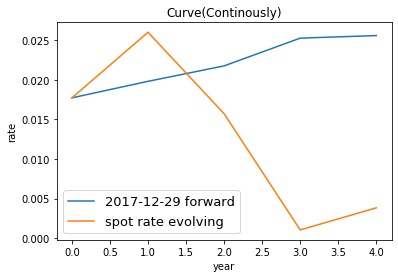

In [11]:
spot_forward = f[["2017-12-29"]].copy()
spot_forward["spot rate"] = spot_rate.values[:5, 0]
spot_forward.columns = ["2017-12-29 forward", "spot rate evolving"]
spot_forward.plot()
plt.title("Curve(Continously)")
plt.xlabel("year")
plt.ylabel("rate")

# 2. Carry Trade

## 2.1

Suppose it is December 2017, and you determine to implement a carry trade with the following specification...

* Long \\$100 million of the 5-year zero-coupon bond (maturing Dec 2022.)
* Short \\$100 million of the 1-year zero-coupon bond (maturing Dec 2018.)
* Assume there is a 2% haircut on each side of the trade, so it requires \\$4 million of investor capital to initiate it.

Trace the profit and loss each year.
* Note that each year you will roll over the short position until the trade concludes in Dec 2022.

Calculate the total profit and loss when the trade concludes in Dec 2022.
* Calculate the total return on the initial \\$4 million of investor capital.

In [13]:
sample

,1,2,3,4,5
date,,,,,
2017-12-29,0.9824,0.9631,0.9424,0.9189,0.8956
2018-12-31,0.9743,0.9520,0.9293,0.9058,0.8826
2019-12-31,0.9844,0.9689,0.9530,0.9357,0.9189
2020-12-31,0.9990,0.9975,0.9953,0.9895,0.9815
2021-12-31,0.9962,0.9855,0.9713,0.9549,0.9387
2022-12-30,0.9546,0.9162,0.8833,0.8510,0.8203


In [14]:
pos = 1e8
haircut = 0.02
PnL = pd.DataFrame(columns=["long pos", "long pnl", "short pos", "short pnl", "haircut", "total pnl"], index=sample.index)
PnL.iloc[0] = [pos, 0, pos, 0, 2*haircut*pos, 0]
y = 5
for i in range(1, 6):
    date = PnL.index[i]
    pre_date = PnL.index[i-1]
    # short 1 year, roll over
    PnL.loc[date, "short pos"] = PnL.loc[pre_date, "short pos"] / sample.loc[pre_date, 1]
    PnL.loc[date, "haircut"] = PnL.loc[date, "short pos"] * haircut

    # long five year
    if y > 1:
        PnL.loc[date, "long pos"] = PnL.loc[pre_date, "long pos"] / sample.loc[pre_date, y] * sample.loc[date, y-1]
    else:
        PnL.loc[date, "long pos"] = PnL.loc[pre_date, "long pos"] / sample.loc[pre_date, y]
    y -= 1


In [15]:
PnL["long pnl"] = PnL["long pos"].diff().fillna(0)
PnL["short pnl"] = PnL["short pos"].diff().fillna(0)
PnL["total pnl"] = PnL["long pnl"] - PnL["short pnl"] # - PnL["haircut"]
PnL.iloc[0, 5] = 0
PnL["cumulative pnl"] = PnL["total pnl"].cumsum()
PnL

,long pos,long pnl,short pos,short pnl,haircut,total pnl,cumulative pnl
date,,,,,,,
2017-12-29,100000000.0,0.0000e+00,100000000.0,0.0000e+00,4000000.0,0.0000e+00,0.0000e+00
2018-12-31,101134709.3154,1.1347e+06,101789246.5694,1.7892e+06,2035784.9314,-6.5454e+05,-6.5454e+05
2019-12-31,106400629.075,5.2659e+06,104473212.1906,2.6840e+06,2089464.2438,2.5820e+06,1.9274e+06
2020-12-31,111375389.8056,4.9748e+06,106129450.8702,1.6562e+06,2122589.0174,3.3185e+06,5.2459e+06
2021-12-31,111225030.102,-1.5036e+05,106240085.3441,1.1063e+05,2124801.7069,-2.6099e+05,4.9849e+06
2022-12-30,111652299.2732,4.2727e+05,106648204.9299,4.0812e+05,2132964.0986,1.9150e+04,5.0041e+06


In [19]:
total_pnl = PnL["cumulative pnl"][-1] / 4000000.0 * 100
print("Total PnL: {0:.2f} % ".format(total_pnl))

Total PnL: 125.10 % 


## 2.2

How would this trade play out if the path of one-year spot rates equaled the forward rates observed in 2017?

**Answers:** In the end, the portfolio is expected to have a net profit and loss (PnL) of zero, although it may experience fluctuations in gains and losses during the holding period. This is because the current value of the 5-year bond will continue to fluctuate differently from the forward rate observed in 2017 over time.

## 2.3

Given Fact 3 of the *dynamic* (conditional) tests of EH in notebook W.5., do you expect that as of Dec 2022 the long-short trade above looks more or less favorable as of Dec 2022-2027 than it did as of Dec 2017-2022?

**Answers:** Fact 3 demonstrates that when the forward spread is high, it provides a strong indication of potential returns on long-term bonds. As observed from the spread, the period between 2017-2022 has a higher forward-spot rate spread compared to the period between 2022-2027. As a result, the long-short trade mentioned above is expected to be less favorable from December 2022 to 2027, compared to the period from 2017 to 2022.

In [20]:
pd.DataFrame(f["2017-12-29"].values - spot_rate.loc["2017-12-29"].values, columns=["spread: 2017-12-29"])

,spread: 2017-12-29
0,0.0000
1,0.0010
2,0.0020
3,0.0041
4,0.0036


In [21]:
pd.DataFrame(f["2022-12-30"].values - spot_rate.loc["2022-12-30"].values, columns=["spread: 2022-12-30"])

,spread: 2022-12-30
0,0.0000
1,-0.0027
2,-0.0048
3,-0.0031
4,-0.0028
